**Cutomized Squeeze and Excitation block on Encoder stages of U-Net**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Dataset

/content/drive/MyDrive/Dataset


In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-lh57ybnp
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-lh57ybnp
  Resolved https://github.com/tensorflow/examples.git to commit fed63294c10c71b7da028e0e75de9ff68ac56d17
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1741282361.1454860421494433302046033067432040489300359736599-py3-none-any.whl size=301643 sha256=228f5f51c1c90f8a3076ff75463b0f260ad9248d89f989994778585a1dbaf738
  Stored in directory: /tmp/pip-ephem-wheel-cache-1hb48fjr/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


Install necessary libraries

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

print(AUTOTUNE)

-1


GPU access

In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


Fix the dimension of images, batch size and buffer size

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

Peform Pre-processing on images

In [ ]:
def random_crop(image):
  # Remove the batch dimension
  image = tf.squeeze(image, axis=0)

  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  # Add the batch dimension back
  cropped_image = tf.expand_dims(cropped_image, axis=0)
  # get cropped image [1,256,256,3]
  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  # converts tensor into specified data type 32-bit float
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # Ensure the image has 3 color channels (RGB)
  # if not convert into RGB
  if image.shape[-1] != 3:
    image = tf.image.grayscale_to_rgb(image)

  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image):
  image = normalize(image)
  return image

Create a pipeline to create dataset for train, test of Fundus and OCT-A images

In [ ]:
def load_custom_dataset(data_dir, image_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE):
    """
    Load a custom dataset from specified directories and apply preprocessing steps.

    Args:
        data_dir (str): The root directory containing 'trainA', 'trainB', 'testA', and 'testB' folders.
        image_size (tuple): The size to resize the images to, e.g., (256, 256).
        batch_size (int): The batch size for the dataset.
        buffer_size (int): The buffer size for shuffling.

    Returns:
        train_horses (tf.data.Dataset): Dataset for 'trainA' images.
        train_zebras (tf.data.Dataset): Dataset for 'trainB' images.
        test_horses (tf.data.Dataset): Dataset for 'testA' images.
        test_zebras (tf.data.Dataset): Dataset for 'testB' images.
    """
    # Define data directories
    trainA_dir = os.path.join(data_dir, 'trainA')
    trainB_dir = os.path.join(data_dir, 'trainB')
    testA_dir = os.path.join(data_dir, 'testA')
    testB_dir = os.path.join(data_dir, 'testB')

    # Define image preprocessing functions (preprocess_image_train and preprocess_image_test)
    # Make sure to define these functions according to your specific requirements.
    # pipeline: To load images, resize images, shuffle, cache (Faster access), custom pre-processing, shuffle again, batches

    train_fundus = tf.keras.utils.image_dataset_from_directory(
        trainA_dir,
        label_mode=None,
        image_size=image_size,
        batch_size=batch_size,
        shuffle=True
    ).cache().map(preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(buffer_size).batch(batch_size)

    train_OCTA = tf.keras.utils.image_dataset_from_directory(
        trainB_dir,
        label_mode=None,
        image_size=image_size,
        batch_size=batch_size,
        shuffle=True
    ).cache().map(preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(buffer_size).batch(batch_size)

    test_fundus = tf.keras.utils.image_dataset_from_directory(
        testA_dir,
        label_mode=None,
        image_size=image_size,
        batch_size=batch_size,
    ).map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size).batch(batch_size)

    test_OCTA = tf.keras.utils.image_dataset_from_directory(
        testB_dir,
        label_mode=None,
        image_size=image_size,
        batch_size=batch_size,
    ).map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size).batch(batch_size)

    return train_fundus, train_OCTA, test_fundus, test_OCTA

Install necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
#import theano
from PIL import Image
from numpy import *

In [ ]:
# SKLEARN
from sklearn.utils import shuffle
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

In [ ]:
# input image dimensions
img_rows, img_cols = 400,400

# number of channels
img_channels = 1

Read no.of files for train and test of Fundus and OCT-A images

In [ ]:
data_dir='/content/drive/MyDrive/Dataset'
train_fundus, train_OCTA, test_fundus, test_OCTA=load_custom_dataset(data_dir)

Found 143 files.
Found 143 files.
Found 19 files.
Found 19 files.


Remove First dimension of images

In [ ]:
def remove_batch_dimension(image):
    # Remove the first dimension
    return image[0]

In [ ]:
train_fundus = train_fundus.map(remove_batch_dimension)
train_OCTA = train_OCTA.map(remove_batch_dimension)
test_fundus = test_fundus.map(remove_batch_dimension)
test_OCTA = test_OCTA.map(remove_batch_dimension)

Get a sample image for Fundus and OCT-A

In [ ]:
sample_fundus = next(iter(train_fundus))
sample_OCTA = next(iter(train_OCTA))
# sample_ct_jittered=sample_ct[0]
# sample_mri_jittered=sample_mri[0]

In [ ]:
sample_fundus.shape

TensorShape([1, 256, 256, 3])

Create a Instance Normalization

In [ ]:
import tensorflow as tf

class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(name='scale',
                                     shape=input_shape[-1:],
                                     initializer='ones',
                                     trainable=True)
        self.offset = self.add_weight(name='offset',
                                      shape=input_shape[-1:],
                                     initializer='zeros',
                                     trainable=True)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.scale * normalized + self.offset

Customized Threshold-based SE block

In [ ]:
class ThresholdSEBlock(tf.keras.layers.Layer):
    def __init__(self, channels, reduction=16, threshold=0.5):
        super(ThresholdSEBlock, self).__init__()
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(channels // reduction, activation='relu')
        self.fc2 = layers.Dense(channels, activation='sigmoid')
        self.threshold = threshold

    def call(self, inputs):
        x = self.global_avg_pool(inputs)
        x = self.fc1(x)
        x = self.fc2(x)
        # Apply threshold
        x = tf.where(x > self.threshold, x, tf.zeros_like(x))
        x = tf.reshape(x, [-1, 1, 1, x.shape[-1]])  # Reshape for scaling
        return inputs * x

Entropy based Squeeze and Excitation

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class EntropySEBlock(tf.keras.layers.Layer):
    def _init_(self, channels, reduction=16, epsilon=1e-8):
        super(EntropySEBlock, self)._init_()
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(channels // reduction, activation='relu')
        self.fc2 = layers.Dense(channels, activation='sigmoid')
        self.epsilon = epsilon

    def call(self, inputs):
        x = self.global_avg_pool(inputs)
        x = self.fc1(x)
        attention = self.fc2(x)  # shape: (batch, channels)

        # Compute entropy per channel
        entropy = -attention * tf.math.log(attention + self.epsilon) - \
                  (1.0 - attention) * tf.math.log(1.0 - attention + self.epsilon)

        # Optionally normalize entropy to [0,1]
        entropy = entropy / tf.math.log(2.0)

        # Scale attention by entropy
        scaled_attention = attention * entropy  # shape: (batch, channels)

        # Reshape for channel-wise multiplication
        scaled_attention = tf.reshape(scaled_attention, [-1, 1, 1, scaled_attention.shape[-1]])

        return inputs * scaled_attention

U-Net Generator with Customized Threshold-based SE block

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def downsample(filters, size, apply_batchnorm=True, norm_type='batchnorm', use_se=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        if norm_type.lower() == 'batchnorm':
            result.add(layers.BatchNormalization())
        elif norm_type.lower() == 'instancenorm':
            result.add(InstanceNormalization())

    result.add(layers.LeakyReLU())
    # 2nd conv layer
    result.add(
        layers.Conv2D(filters, size, strides=1, padding='same',
                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        if norm_type.lower() == 'batchnorm':
            result.add(layers.BatchNormalization())
        elif norm_type.lower() == 'instancenorm':
            result.add(InstanceNormalization())

    result.add(layers.LeakyReLU())
    # 3rd conv layer
    # 2nd conv layer
    result.add(
        layers.Conv2D(filters, size, strides=1, padding='same',
                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        if norm_type.lower() == 'batchnorm':
            result.add(layers.BatchNormalization())
        elif norm_type.lower() == 'instancenorm':
            result.add(InstanceNormalization())

    result.add(layers.LeakyReLU())
    result.add(ThresholdSEBlock(filters, reduction=16, threshold=0.5))

    return result

def upsample(filters, size, apply_dropout=False, norm_type='batchnorm'):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())
    result.add(layers.ReLU())
    # 2nd conv layer
    result.add(
        layers.Conv2DTranspose(filters, size, strides=1,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())
    result.add(layers.ReLU())
    # 3rd conv layer
    result.add(
        layers.Conv2DTranspose(filters, size, strides=1,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def unet_generator1(output_channels, norm_type='batchnorm'):
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False, norm_type=norm_type, use_se=True),  # (bs, 128, 128, 64)
        downsample(128, 4, norm_type=norm_type, use_se=True),  # (bs, 64, 64, 128)
        downsample(256, 4, norm_type=norm_type, use_se=True),  # (bs, 32, 32, 256)
        downsample(512, 4, norm_type=norm_type, use_se=True),  # (bs, 16, 16, 512)
        #downsample(512, 4, norm_type=norm_type, use_se=True),  # (bs, 8, 8, 512)
        #downsample(512, 4, norm_type=norm_type, use_se=True),  # (bs, 4, 4, 512)
        #downsample(512, 4, norm_type=norm_type, use_se=True),  # (bs, 2, 2, 512)
        #downsample(512, 4, norm_type=norm_type, use_se=True),  # (bs, 1, 1, 512)
        ]


    up_stack = [
        #upsample(512, 4, apply_dropout=True, norm_type=norm_type),  # (bs, 2, 2, 1024)
        #upsample(512, 4, apply_dropout=True, norm_type=norm_type),  # (bs, 4, 4, 1024)
        #upsample(512, 4, apply_dropout=True, norm_type=norm_type),  # (bs, 8, 8, 1024)
        #upsample(512, 4, norm_type=norm_type),  # (bs, 16, 16, 1024)
        upsample(256, 4, norm_type=norm_type),  # (bs, 32, 32, 512)
        upsample(128, 4, norm_type=norm_type),  # (bs, 64, 64, 256)
        upsample(64, 4, norm_type=norm_type),   # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(output_channels, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (bs, 256, 256, output_channels)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

cGAN with cutomized U-Net generator and pix2pix discriminator

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = unet_generator1(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator1(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Sample Conversion: From Fundus to OCT-A and OCT-A to Fundus

Define GAN Loss functions

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Define Optimizer

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)

Create Checkpoints

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
EPOCHS = 2

Function to create a predicted image from input image

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Train a Model

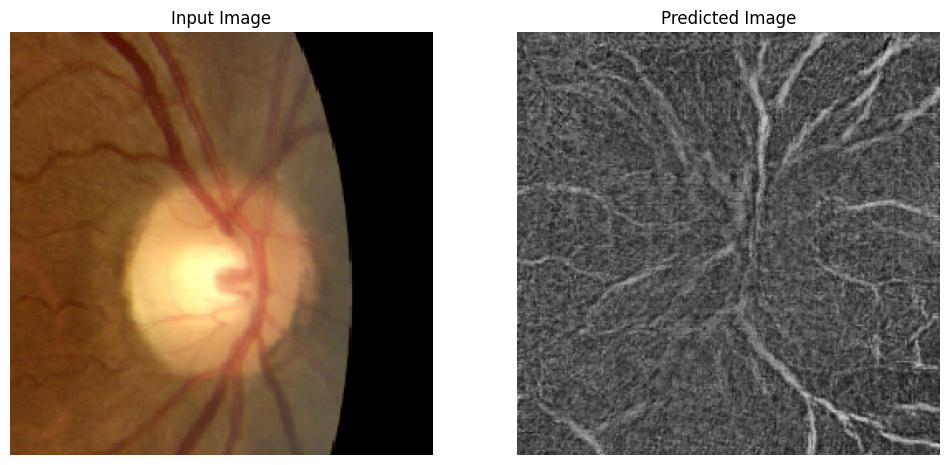

Time taken for epoch 2 is 60.73983025550842 sec



In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_fundus, train_OCTA)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_fundus)

  if (epoch + 1) % 10 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
# save the model

# Create save directory
save_dir = '/content/drive/MyDrive/Colab Notebooks/Fundus_OCTA_GAN/Saved_Model'
os.makedirs(save_dir, exist_ok=True)

# Save weights with correct filename format
generator_g.save(os.path.join(save_dir, 'generator_g.h5'))

In [ ]:
# Save weights
# Create save directory
save_dir = '/content/drive/MyDrive/Colab Notebooks/Fundus_OCTA_GAN/Saved_Model'
os.makedirs(save_dir, exist_ok=True)

# Save weights with correct filename format
generator_g.save_weights(os.path.join(save_dir, 'generator_g.weights.h5'))  # Note the .weights.h5 suffix
generator_f.save_weights(os.path.join(save_dir, 'generator_f.weights.h5'))

print(f"Models saved successfully at: {save_dir}")

Models saved successfully at: /content/drive/MyDrive/Colab Notebooks/Fundus_OCTA_GAN/Saved_Model


In [ ]:
# Save the model as a pickle file
import pickle

# Save model architecture and weights separately
model_dict = {
    "architecture": generator_g.to_json(),
    "weights": generator_g.get_weights()
}

# Save as a pickle file
with open("model.pkl", "wb") as f:
    pickle.dump(model_dict, f)